#### 1) Загрузите данные ex5data1.mat из файла.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = '/home/ataleckij/Projects/university/mo/Data/Lab 5/'

In [4]:
files_names = os.listdir(DATA_PATH)
print(files_names)
files_paths = {name: os.path.join(DATA_PATH, name) for name in files_names}

['emailSample1.txt', 'emailSample2.txt', 'ex5data2.mat', 'spamTest.mat', 'spamSample2.txt', 'ex5data3.mat', 'ex5data1.mat', 'vocab.txt', 'spamSample1.txt', 'spamTrain.mat']


In [5]:
from scipy.io import loadmat

data1 = loadmat(files_paths['ex5data1.mat'])

X, y = data1['X'], data1['y'].flatten()
print(X.shape, y.shape)

(51, 2) (51,)


#### 2) Постройте график для загруженного набора данных: по осям - переменные X1, X2, а точки, принадлежащие различным классам должны быть обозначены различными маркерами.

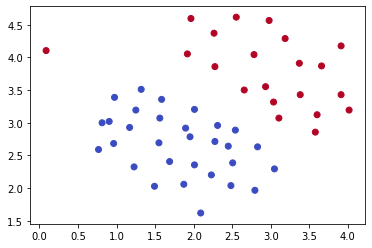

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.show()

#### 3) Обучите классификатор с помощью библиотечной реализации SVM с линейным ядром на данном наборе.

In [9]:
from sklearn.svm import SVC

svc = SVC(gamma='auto', kernel='linear').fit(X, y)

#### 4) Постройте разделяющую прямую для классификаторов с различными параметрами C = 1, C = 100 (совместно с графиком из пункта 2). Объясните различия в полученных прямых?


In [10]:
def plot_svc(fitted_svc_model, X, y, show=True, frame=0.15):
    x0_min, x0_max = X[:, 0].min(), X[:, 0].max()
    x1_min, x1_max = X[:, 1].min(), X[:, 1].max()
    x_min, x_max = x0_min - (x1_max-x1_min)*frame, x0_max + (x0_max-x0_min)*frame
    y_min, y_max = x1_min - (x1_max-x1_min)*frame, x1_max + (x1_max-x1_min)*frame
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = fitted_svc_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
#     plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha=0.5)
    if show:
        plt.show()

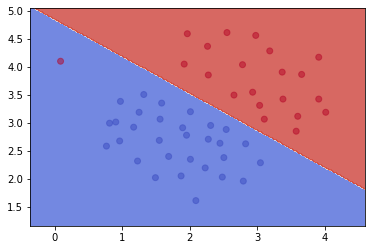

In [11]:
plot_svc(svc, X, y)

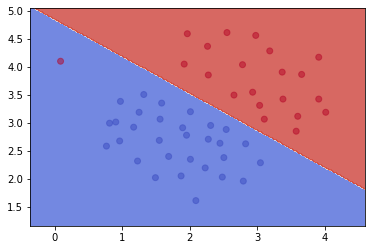

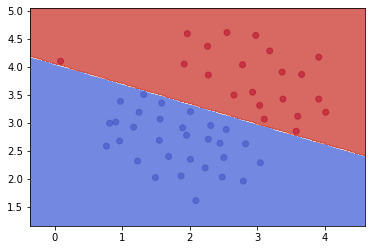

In [12]:
svc1 = SVC(gamma='auto', C=1, kernel='linear').fit(X, y)
plot_svc(svc1, X, y)

svc2 = SVC(gamma='auto', C=100, kernel='linear').fit(X, y)
plot_svc(svc2, X, y)

#### 5) Реализуйте функцию вычисления Гауссового ядра для алгоритма SVM.

In [13]:
from functools import wraps

def gaussian_func(X, l, sigma):
    sigma_sqr = sigma ** 2
    return np.exp(-np.sum((X-l)**2, axis=1) / (2*sigma_sqr))

class GaussianKernel:
    def __init__(self, sigma):
        self.sigma = sigma
    
    def __call__(self, X1, X2):
        gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
        for j, lj in enumerate(X2):
            gram_matrix[:, j] = gaussian_func(X1, lj, self.sigma)
        return gram_matrix

#### 6) Загрузите данные ex5data2.mat из файла.

In [14]:
data2 = loadmat(files_paths['ex5data2.mat'])

X2, y2 = data2['X'], data2['y'].flatten()
print(X2.shape, y2.shape)

(863, 2) (863,)


#### 7) Обработайте данные с помощью функции Гауссового ядра.
#### 8) Обучите классификатор SVM.

In [16]:
svc_g = SVC(gamma='scale', kernel=GaussianKernel(sigma=0.1))
svc_g.fit(X2, y2)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<__main__.GaussianKernel object at 0x7f4b43428a20>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

#### 9) Визуализируйте данные вместе с разделяющей кривой (аналогично пункту 4).

0.9895712630359212


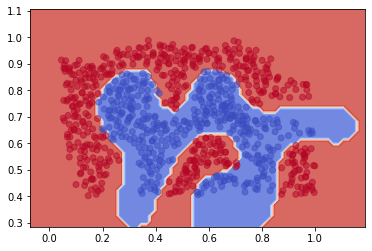

In [17]:
print((svc_g.predict(X2) == y2).mean())

plot_svc(svc_g, X2, y2, frame=0.2)

#### 10) Загрузите данные ex5data3.mat из файла.

In [18]:
data3 = loadmat(files_paths['ex5data3.mat'])

X3, y3 = data3['X'], data3['y'].flatten()
print(X3.shape, y3.shape)

X3_val, y3_val = data3['Xval'], data3['yval'].flatten()
print(X3_val.shape, y3_val.shape)

(211, 2) (211,)
(200, 2) (200,)


#### 11) Вычислите параметры классификатора SVM на обучающей выборке, а также подберите параметры C и σ2 на валидационной выборке.

In [21]:
class GaussianSVC(SVC):
    def __init__(self, C=1, sigma=1):
        self._kernel = GaussianKernel(sigma=sigma)
        return super().__init__(C, kernel=self._kernel)
    
    def get_params(self, deep=False):
        return {'sigma': self._kernel.sigma, 'C': super().get_params(deep=deep)['C']}
    
    def set_params(self, **params):
        self._kernel.sigma = params['sigma']
        del params['sigma']
        return super().set_params(**params)

In [22]:
from sklearn.model_selection import GridSearchCV

def search_best_gaussian_svc(X, y, cv=3, params=None):
    params = params or {
        'sigma': [0.01, 0.1, 0.5, 1, 5], 
        'C': [1, 5, 10, 50, 100]
    }
    gsvc = GridSearchCV(GaussianSVC(), params, cv=cv)
    return gsvc.fit(X, y).best_estimator_

gsvc_best = search_best_gaussian_svc(X3, y3)
gsvc_best

/home/ataleckij/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GaussianSVC(C=5, sigma=0.1)

#### 12) Визуализируйте данные вместе с разделяющей кривой (аналогично пункту 4).

0.943127962085308


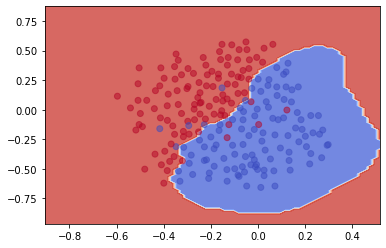

0.955


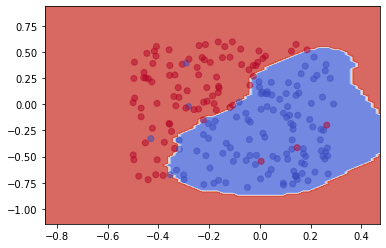

In [23]:
print((gsvc_best.predict(X3) == y3).mean())
plot_svc(gsvc_best, X3, y3, frame=0.25)

print((gsvc_best.predict(X3_val) == y3_val).mean())
plot_svc(gsvc_best, X3_val, y3_val, frame=0.25)

#### 13) Загрузите данные spamTrain.mat из файла.
#### 15) Загрузите данные spamTest.mat из файла.

In [24]:
data4 = loadmat(files_paths['spamTrain.mat'])

X4, y4 = data4['X'], data4['y'].flatten()
print(X4.shape, y4.shape)


data4_test = loadmat(files_paths['spamTest.mat'])

X4_test, y4_test = data4_test['Xtest'], data4_test['ytest'].flatten()
print(X4_test.shape, y4_test.shape)

(4000, 1899) (4000,)
(1000, 1899) (1000,)


#### 16) Подберите параметры C и σ2.

In [235]:
params = {
    'sigma': [2, 5, 10], 
    'C': [5, 10, 25, 50]
}

gsvc4_best = search_best_gaussian_svc(X4, y4, params=params, cv=2)
gsvc4_best  # GaussianSVC(C=10, sigma=10)

2


GaussianSVC(C=10, sigma=10)

In [25]:
gsvc4_best = GaussianSVC(C=10, sigma=10).fit(X4, y4)

In [26]:
print((gsvc4_best.predict(X4) == y4).mean())
print((gsvc4_best.predict(X4_test) == y4_test).mean())

0.99925
0.992


In [27]:
from collections import Counter

print(Counter(y4))
print(Counter(y4_test))

Counter({0: 2723, 1: 1277})
Counter({0: 692, 1: 308})


In [28]:
from sklearn.metrics import f1_score

print(f1_score(gsvc4_best.predict(X4), y4))
print(f1_score(gsvc4_best.predict(X4_test), y4_test))

0.9988239905919247
0.9870550161812298


#### 17) Реализуйте функцию предобработки текста письма, включающую в себя:
- перевод в нижний регистр;
- удаление HTML тэгов;
- замена URL на одно слово (например, “httpaddr”);
- замена email-адресов на одно слово (например, “emailaddr”);
- замена чисел на одно слово (например, “number”);
- замена знаков доллара ($) на слово “dollar”;
- замена форм слов на исходное слово (например, слова “discount”, “discounts”, “discounted”, “discounting” должны быть заменены на слово “discount”). Такой подход называется stemming;
- остальные символы должны быть удалены и заменены на пробелы, т.е. в результате получится текст, состоящий из слов, разделенных пробелами.


In [280]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ataleckij/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
import re
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import word_tokenize 

ps = PorterStemmer() 

def _remove_html(raw_html):
    html_tag_regex = re.compile('<.*?>')
    return re.sub(html_tag_regex, '', raw_html)

def _replace_urls(text):
#     url_regex = re.compile(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+')
    url_regex = re.compile(r'^(?:(ftp|http|https)?:\/\/)?(?:[\w-]+\.)+([a-z]|[A-Z]|[0-9]){2,6}$')
    return re.sub(url_regex, ' httpaddr ', text)

def _replace_numbers(text):
    number_regex = re.compile(r'[-+]?\d*[\.,-]\d+|\d+')
    return re.sub(number_regex, ' number ', text)

def _remove_not_letters(text):
    not_letters_regex = re.compile(r'[^A-Za-z ]')
    return re.sub(not_letters_regex, '', text)

def process_text(text):
    # перевод в нижний регистр;
    text = text.lower()
    
    # удаление HTML тэгов;
    text = _remove_html(text)
    
    # замена URL на одно слово (например, “httpaddr”);
    text = _replace_urls(text)
    
    # замена чисел на одно слово (например, “number”);
    text = _replace_numbers(text)
    
    # замена знаков доллара ($) на слово “dollar”;
    text = text.replace('$', ' dollar ')
    
    # остальные символы должны быть удалены и заменены на пробелы, т.е. в результате получится текст, 
    #   состоящий из слов, разделенных пробелами.
    text = _remove_not_letters(text)
    
    # замена форм слов на исходное слово (например, слова “discount”, “discounts”, “discounted”, 
    #   “discounting” должны быть заменены на слово “discount”). Такой подход называется stemming;
    ps = LancasterStemmer()
    return [ps.stem(word) for word in word_tokenize(text)]

#### 18) Загрузите коды слов из словаря vocab.txt.

In [30]:
vocab = pd.read_csv(files_paths['vocab.txt'], sep='\t', header=None)

In [31]:
vocab

,0,1
0,1,aa
1,2,ab
2,3,abil
3,4,abl
4,5,about
...,...,...
1894,1895,your
1895,1896,yourself
1896,1897,zdnet
1897,1898,zero


In [32]:
word_to_code = {}
code_to_word = {}

for code, word in vocab.values:
    word_to_code[word] = code
    code_to_word[code] = word

In [34]:
len(word_to_code)

1899

In [35]:
max(code_to_word)

1899

#### 19) Реализуйте функцию замены слов в тексте письма после предобработки на их соответствующие коды.

In [36]:
def encode_words(words_list, word_to_code):
    return [word_to_code[word] 
                if word in word_to_code 
                else 0
            for word in words_list]

#### 20) Реализуйте функцию преобразования текста письма в вектор признаков (в таком же формате как в файлах spamTrain.mat и spamTest.mat).

In [37]:
def vectorize_words_codes(words_codes_list, size):
    words_vector = np.zeros(size)
    words_vector[words_codes_list] = 1
    return words_vector

#### 21) Проверьте работу классификатора на письмах из файлов emailSample1.txt, emailSample2.txt, spamSample1.txt и spamSample2.txt.

In [38]:
def classify_file(file_name, svc, word_to_code):
    with open(files_paths[file_name], 'rt') as f:
        text = f.read()
    print(text)
    words_list = process_text(text)
    words_codes_list = encode_words(words_list, word_to_code)
    words_vector =  vectorize_words_codes(words_codes_list, size=len(word_to_code))
    return svc.predict([words_vector])[0]

In [39]:
classify_file('emailSample1.txt', gsvc4_best, word_to_code)

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




0

In [40]:
classify_file('emailSample2.txt', gsvc4_best, word_to_code)

Folks,
 
my first time posting - have a bit of Unix experience, but am new to Linux.

 
Just got a new PC at home - Dell box with Windows XP. Added a second hard disk
for Linux. Partitioned the disk and have installed Suse 7.2 from CD, which went
fine except it didn't pick up my monitor.
 
I have a Dell branded E151FPp 15" LCD flat panel monitor and a nVidia GeForce4
Ti4200 video card, both of which are probably too new to feature in Suse's default
set. I downloaded a driver from the nVidia website and installed it using RPM.
Then I ran Sax2 (as was recommended in some postings I found on the net), but
it still doesn't feature my video card in the available list. What next?
 
Another problem. I have a Dell branded keyboard and if I hit Caps-Lock twice,
the whole machine crashes (in Linux, not Windows) - even the on/off switch is
inactive, leaving me to reach for the power cable instead.
 
If anyone can help me in any way with these probs., I'd be really grateful -
I've searched the 'ne

0

In [41]:
classify_file('spamSample1.txt', gsvc4_best, word_to_code)

Do You Want To Make $1000 Or More Per Week?

 

If you are a motivated and qualified individual - I 
will personally demonstrate to you a system that will 
make you $1,000 per week or more! This is NOT mlm.

 

Call our 24 hour pre-recorded number to get the 
details.  

 

000-456-789

 

I need people who want to make serious money.  Make 
the call and get the facts. 

Invest 2 minutes in yourself now!

 

000-456-789

 

Looking forward to your call and I will introduce you 
to people like yourself who
are currently making $10,000 plus per week!

 

000-456-789



3484lJGv6-241lEaN9080lRmS6-271WxHo7524qiyT5-438rjUv5615hQcf0-662eiDB9057dMtVl72




0

In [42]:
classify_file('spamSample2.txt', gsvc4_best, word_to_code)

Best Buy Viagra Generic Online

Viagra 100mg x 60 Pills $125, Free Pills & Reorder Discount, Top Selling 100% Quality & Satisfaction guaranteed!

We accept VISA, Master & E-Check Payments, 90000+ Satisfied Customers!
http://medphysitcstech.ru





1

#### 22) Также можете проверить его работу на собственных примерах.

#### 23) Создайте свой набор данных из оригинального корпуса текстов
http://spamassassin.apache.org/old/publiccorpus
#### 24) Постройте собственный словарь.

In [43]:
from tqdm import tqdm

NEW_DATA_DIR_PATH = 'data/'
HAM_DIRS_NAMES = ['easy_ham_1', 'easy_ham_2', 'hard_ham']
SPAM_DIRS_NAMES = ['spam', 'spam_2']

features, labels = [], []
custom_vocab = set()

for dirs_names, label in ((HAM_DIRS_NAMES, 0), (SPAM_DIRS_NAMES, 1)):
    for dir_name in dirs_names:
        dir_path = os.path.join(NEW_DATA_DIR_PATH, dir_name)
        _, _, files_names = next(os.walk(dir_path))
        for file_name in tqdm(files_names):
            file_path = os.path.join(dir_path, file_name)
            with open(file_path, 'rt', encoding='utf-8', errors='ignore') as f:
                try:
                    text = f.read()
                except Exception as e:
                    print(e)
            words_list = process_text(text)
            custom_vocab |= set(words_list)
            features.append(words_list)
            labels.append(label)

100%|██████████| 1397/1397 [00:22<00:00, 63.23it/s]


In [44]:
print(len(features))
print(len(custom_vocab))
print(Counter(labels))

6051
215760
Counter({0: 4153, 1: 1898})


In [45]:
custom_word_to_code = {'EMPTY_TOKEN': 0}

for code, word in enumerate(custom_vocab):
    custom_word_to_code[word] = code + 1

# del custom_vocab

In [53]:
from scipy.sparse import lil_matrix

words_vectors = lil_matrix((len(features), len(custom_word_to_code)), dtype=np.int8)

i = 0
for words_list in tqdm(features):
    words_codes_list = encode_words(words_list, custom_word_to_code)
    words_vector = vectorize_words_codes(words_codes_list, size=len(custom_word_to_code))
    words_vectors[i] = words_vector
    i += 1



  0%|          | 0/6051 [00:00<?, ?it/s]

  0%|          | 11/6051 [00:00<00:59, 101.53it/s]

  0%|          | 23/6051 [00:00<00:57, 105.53it/s]

  1%|          | 34/6051 [00:00<00:57, 105.37it/s]

  1%|          | 46/6051 [00:00<00:56, 106.93it/s]

  1%|          | 57/6051 [00:00<00:56, 106.76it/s]

  1%|          | 67/6051 [00:00<00:57, 103.87it/s]

  1%|▏         | 78/6051 [00:00<00:57, 104.77it/s]

  1%|▏         | 90/6051 [00:00<00:54, 108.77it/s]

  2%|▏         | 103/6051 [00:00<00:52, 113.50it/s]

  2%|▏         | 115/6051 [00:01<00:52, 112.06it/s]

  2%|▏         | 127/6051 [00:01<00:52, 112.16it/s]

  2%|▏         | 139/6051 [00:01<00:52, 112.19it/s]

  3%|▎         | 152/6051 [00:01<00:51, 115.18it/s]

  3%|▎         | 164/6051 [00:01<00:51, 113.91it/s]

  3%|▎         | 176/6051 [00:01<00:51, 114.30it/s]

  3%|▎         | 188/6051 [00:01<00:52, 112.61it/s]

  3%|▎         | 200/6051 [00:01<00:55, 104.64it/s]

  3%|▎         | 211/6051 [00:01<01:01, 94.59it/s] 

  4%|▎    

 52%|█████▏    | 3133/6051 [00:29<00:26, 110.13it/s]

 52%|█████▏    | 3145/6051 [00:29<00:26, 110.22it/s]

 52%|█████▏    | 3157/6051 [00:30<00:26, 108.77it/s]

 52%|█████▏    | 3168/6051 [00:30<00:26, 109.02it/s]

 53%|█████▎    | 3180/6051 [00:30<00:25, 111.12it/s]

 53%|█████▎    | 3192/6051 [00:30<00:25, 113.26it/s]

 53%|█████▎    | 3204/6051 [00:30<00:24, 113.95it/s]

 53%|█████▎    | 3216/6051 [00:30<00:25, 112.81it/s]

 53%|█████▎    | 3228/6051 [00:30<00:25, 111.02it/s]

 54%|█████▎    | 3240/6051 [00:30<00:25, 109.98it/s]

 54%|█████▎    | 3252/6051 [00:30<00:25, 108.55it/s]

 54%|█████▍    | 3264/6051 [00:30<00:25, 110.51it/s]

 54%|█████▍    | 3276/6051 [00:31<00:24, 112.83it/s]

 54%|█████▍    | 3288/6051 [00:31<00:24, 113.36it/s]

 55%|█████▍    | 3300/6051 [00:31<00:24, 113.57it/s]

 55%|█████▍    | 3312/6051 [00:31<00:24, 114.08it/s]

 55%|█████▍    | 3324/6051 [00:31<00:23, 114.49it/s]

 55%|█████▌    | 3336/6051 [00:31<00:23, 114.99it/s]

 55%|█████▌    | 3349/6051 [

In [71]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=400)
dense_words_vectors = tsvd.fit_transform(words_vectors)

#### 25) Как изменилось качество классификации? Почему?

In [58]:
final_gsvc = GaussianSVC(C=10, sigma=10).fit(dense_words_vectors, labels)

In [59]:
print(f1_score(final_gsvc.predict(dense_words_vectors), labels))

0.9994731296101159


In [72]:
def classify_file_with_sparce(file_name, svc, word_to_code):
    with open(files_paths[file_name], 'rt') as f:
        text = f.read()
    print(text)
    words_list = process_text(text)
    words_codes_list = encode_words(words_list, word_to_code)
    words_vector =  vectorize_words_codes(words_codes_list, size=len(word_to_code))
    sparce_words_vectors = lil_matrix([words_vector])
    dense_words_vector = tsvd.transform(sparce_words_vectors)[0]
    return svc.predict([dense_words_vector])[0]

In [73]:
classify_file_with_sparce('emailSample1.txt', final_gsvc, custom_word_to_code)

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




0

In [75]:
classify_file_with_sparce('emailSample2.txt', final_gsvc, custom_word_to_code)

Folks,
 
my first time posting - have a bit of Unix experience, but am new to Linux.

 
Just got a new PC at home - Dell box with Windows XP. Added a second hard disk
for Linux. Partitioned the disk and have installed Suse 7.2 from CD, which went
fine except it didn't pick up my monitor.
 
I have a Dell branded E151FPp 15" LCD flat panel monitor and a nVidia GeForce4
Ti4200 video card, both of which are probably too new to feature in Suse's default
set. I downloaded a driver from the nVidia website and installed it using RPM.
Then I ran Sax2 (as was recommended in some postings I found on the net), but
it still doesn't feature my video card in the available list. What next?
 
Another problem. I have a Dell branded keyboard and if I hit Caps-Lock twice,
the whole machine crashes (in Linux, not Windows) - even the on/off switch is
inactive, leaving me to reach for the power cable instead.
 
If anyone can help me in any way with these probs., I'd be really grateful -
I've searched the 'ne

0

In [76]:
classify_file_with_sparce('spamSample1.txt', final_gsvc, custom_word_to_code)

Do You Want To Make $1000 Or More Per Week?

 

If you are a motivated and qualified individual - I 
will personally demonstrate to you a system that will 
make you $1,000 per week or more! This is NOT mlm.

 

Call our 24 hour pre-recorded number to get the 
details.  

 

000-456-789

 

I need people who want to make serious money.  Make 
the call and get the facts. 

Invest 2 minutes in yourself now!

 

000-456-789

 

Looking forward to your call and I will introduce you 
to people like yourself who
are currently making $10,000 plus per week!

 

000-456-789



3484lJGv6-241lEaN9080lRmS6-271WxHo7524qiyT5-438rjUv5615hQcf0-662eiDB9057dMtVl72




1

In [77]:
classify_file_with_sparce('spamSample2.txt', final_gsvc, custom_word_to_code)

Best Buy Viagra Generic Online

Viagra 100mg x 60 Pills $125, Free Pills & Reorder Discount, Top Selling 100% Quality & Satisfaction guaranteed!

We accept VISA, Master & E-Check Payments, 90000+ Satisfied Customers!
http://medphysitcstech.ru





1